# Automatic differentation and training loop

Why autograd is important and how it works: [Why Jacobians are useful to compute gradients in a NN?](https://suzyahyah.github.io/calculus/machine%20learning/2018/04/04/Jacobian-and-Backpropagation.html)

In [1]:
import torch 

We specify that our tensor requires gradient, i.e, we want to compute a derivate w.r.t. that tensor:

In [2]:
x = torch.rand(4,requires_grad=True)
print(x)

tensor([0.5082, 0.3681, 0.5893, 0.8923], requires_grad=True)


Lets start doing some computations and see how pytorch keeps track of those in a [computational graph.](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/)

In [3]:
y = x*5
print(y)

tensor([2.5412, 1.8403, 2.9466, 4.4617], grad_fn=<MulBackward0>)


In [4]:
w = y**2
print(w)

tensor([ 6.4577,  3.3867,  8.6827, 19.9068], grad_fn=<PowBackward0>)


In [5]:
z = w.mean()
print(z)

tensor(9.6085, grad_fn=<MeanBackward0>)


As you can see, each output coming from a computation has an associated `grad_fun` that describes the graph that relates every computation with the initial variable.

so if we want to compute $\frac{\partial z}{\partial x}$ we simply do:

In [6]:
z.backward()
print(x.grad)

tensor([ 6.3530,  4.6007,  7.3666, 11.1543])


`z.backward()` produces a *vector-jacobian product* (i.e, chain-rule) and the gradients are stored in the attribute `.grad` of the variable of interest.

## How to prevent to compute the gradients ?? 

There are 3 main ways:

| Syntax      | Description |
| ----------- | ----------- |
| `with torch.no_grad():`  | Context manager that allows us to do computations without gradients|
|  `x.requires_grad_(False)` | Sets the requires_grad argument to False in place|
| `x.detach()`  | Creates a new tensor without gradient capabilities|


In [7]:
x = torch.rand(5,requires_grad=True)
print(x)
x.requires_grad_(False)
print(x)

tensor([0.6693, 0.0604, 0.7356, 0.2259, 0.2592], requires_grad=True)
tensor([0.6693, 0.0604, 0.7356, 0.2259, 0.2592])


In [8]:
x = torch.rand(5,requires_grad=True)
print(x)
y = x.detach()
print(y)

tensor([0.4828, 0.9198, 0.9978, 0.1897, 0.5830], requires_grad=True)
tensor([0.4828, 0.9198, 0.9978, 0.1897, 0.5830])


In [9]:
with torch.no_grad():
    y=x**2+2
    print(y)

tensor([2.2331, 2.8461, 2.9955, 2.0360, 2.3399])


One thing that we should be careful with is that the attribute `.grad` sums up all the gradients, so in many cases we will need to set gradients to zero after a training iteration.

Dummy example:

In [10]:
W = torch.ones(3, requires_grad=True)

for epoch in range(4):
    out = (W*2).sum()

    out.backward()

    print(W.grad)

tensor([2., 2., 2.])
tensor([4., 4., 4.])
tensor([6., 6., 6.])
tensor([8., 8., 8.])


As you can see at each iteration we are storing the previous values of the gradient, how to solve this? 

In [11]:
W = torch.ones(3, requires_grad=True)

for epoch in range(4):
    out = (W*2).sum()

    out.backward()

    print(W.grad)

    W.grad.zero_()

tensor([2., 2., 2.])
tensor([2., 2., 2.])
tensor([2., 2., 2.])
tensor([2., 2., 2.])


Here `.grad.zero_()` is setting inplace the gradients to zero at the end of each epoch, later we will talk about optimizers and how those have a built-in function that does exactly the same.

## Dummy example: Perceptron with one input, one neuron and one output for one epoch

In [12]:
input = torch.tensor(2.0)
output = torch.tensor(10.0)

W = torch.tensor(1.0, requires_grad=True) # this requires grad since it is our learnable param
pred = W*input
loss = (pred - output)**2 #MSE loss
print(loss)
loss.backward() # backprop

tensor(64., grad_fn=<PowBackward0>)


Try to compute the backprop by hand and compare it with the result!!

## Pytorch Trainig Loop

The basic pytorch model pipeline is given by:

 1. Defining the model
 2. Defining the loss function and the optimizer
 3. Train the model:
    1. Compute the prediction: Forward pass
    2. Compute the gradients: Backward pass
    3. Parameter update
    

In [13]:
import torch.nn as nn 

In [14]:
x = torch.randint(1,10,(5,), dtype=torch.float32)
y = torch.randint(1,10,(5,), dtype=torch.float32)
w = torch.zeros(1, requires_grad=True, dtype=torch.float32)

1. Define the model

In [15]:
def forward(x):
    return w*x

2. Define the loss and optimizer

In [16]:
lr = 0.01
n_iter = 11

In [17]:
loss = nn.MSELoss()
optimizer = torch.optim.SGD([w], lr = lr)

3. Training loop

In [18]:
for epoch in range(n_iter):
    pred = forward(x)
    l = loss(y, pred)
    l.backward() # gradients
    optimizer.step() #update weights
    optimizer.zero_grad() # set grads to 0

    if epoch % 5 == 0:
        print(f'epoch {epoch}: w = {w}, loss = {l}')

epoch 0: w = tensor([0.5120], requires_grad=True), loss = 47.599998474121094
epoch 5: w = tensor([1.0153], requires_grad=True), loss = 21.202138900756836
epoch 10: w = tensor([1.0317], requires_grad=True), loss = 21.174222946166992


We can see how our loss decreases with epochs, and our weight is adjusted.

# Linear Regression

We will use all the knowledge to do a simple linear regression model using pytorch.

In [19]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets 

In [25]:
X,y = datasets.make_regression(n_samples=50,n_features=1,noise=10,random_state=2021)
X = torch.from_numpy(X.astype(np.float32)) # if type is not specified it is a double, we needed as float32
y = torch.from_numpy(y.astype(np.float32)).view(y.shape[0],1) # We reshape y
print(f"y shape:{y.shape}")
n_samples , n_features = X.shape

y shape is:torch.Size([50, 1])


## Define the model

In [26]:
input_size = n_features
output_size = 1
model = nn.Linear(input_size, output_size)

## Optimizer

In [27]:
lr = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

## Training

In [29]:
epochs = 50
for epoch in range(epochs):
    pred = model(X)
    loss = criterion(pred,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (epoch+1) % 10 == 0:
        print(f'epoch:{epoch+1}, loss: {loss.item()}')

epoch:10, loss: 167.85760498046875
epoch:20, loss: 145.57667541503906
epoch:30, loss: 130.62258911132812
epoch:40, loss: 120.56605529785156
epoch:50, loss: 113.789794921875


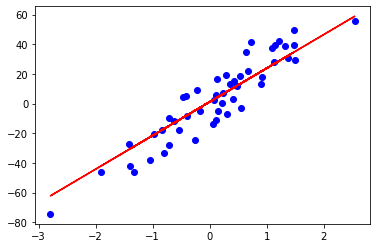

In [30]:
predicted = model(X).detach().numpy()
plt.plot(X,y,'bo')
plt.plot(X,predicted,'r')